# Comprehensive Data Visualization Report

## Overview
This notebook provides a comprehensive visualization analysis of the NYC Crime Dataset after feature engineering. The visualizations are designed to support both exploratory data analysis (EDA) and provide insights for machine learning model interpretation.

## 1. Feature Engineering Pipeline Summary
The final dataset has been processed through a sophisticated preprocessing pipeline including:

### Temporal Features
- **Time-based features**: `HOUR`, `WEEKDAY`, `IS_WEEKEND`, `MONTH`, `SEASON`, `TIME_BUCKET`
- **Temporal aggregations**: Crime patterns across different time scales
- **Cyclical encoding**: Proper handling of temporal periodicity

### Demographic Features
- **Interaction flags**: `SAME_AGE_GROUP`, `SAME_SEX` (suspect-victim matching)
- **Categorical encoding**: One-Hot and Ordinal encoding for demographic variables
- **Missing value imputation**: Sophisticated strategies based on data characteristics

### Geographical Features
- **Spatial coordinates**: `Latitude`, `Longitude` with validation and quality checks
- **POI distances**: Distances from bars, ATMs, metro stations, schools, etc.
- **POI counts**: Proximity-based counts for different facility types
- **Spatial aggregations**: Neighborhood-level crime density features

### Advanced Preprocessing
- **Feature scaling**: StandardScaler and RobustScaler for numeric features
- **Dimensionality reduction**: PCA for high-dimensional categorical data
- **Feature selection**: Mutual information-based selection for ML readiness

### Example Final Columns
`OFNS_DESC`, `LAW_CAT_CD`, `BORO_NM`, `PREM_TYP_DESC`, `Latitude`, `Longitude`, `HOUR`, `WEEKDAY`, `TIME_BUCKET`, `SAME_AGE_GROUP`, `SAME_SEX`, `BAR_DISTANCE`, `NIGHTCLUB_DISTANCE`, `ATM_DISTANCE`, `ATMS_COUNT`, `BARS_COUNT`, `METROS_COUNT`, `SCHOOLS_COUNT`, etc.

## 2. Visualization Methodology
The visualization approach builds upon patterns identified in exploratory notebooks with enhanced statistical rigor:

### Statistical Distributions
- **Pie charts**: Crime type distribution using matplotlib with improved aesthetics
- **Bar plots**: Top crime categories with seaborn styling and statistical annotations
- **Histograms**: Distribution analysis with appropriate binning strategies

### Geographical Analysis
- **Choropleth maps**: Borough-wise crime distribution with statistical significance testing
- **Heat maps**: Spatial hotspot identification using folium with optimized rendering
- **Density plots**: Kernel density estimation for geographic clustering

### Temporal Pattern Analysis
- **Line plots**: Monthly trends with trend decomposition and seasonality analysis
- **Heatmaps**: Day/hour patterns with correlation analysis
- **Box plots**: Hourly distributions by crime type with outlier detection

### Advanced Visualizations
- **Correlation matrices**: Feature relationship analysis with hierarchical clustering
- **Principal component plots**: Dimensionality reduction visualization
- **Feature importance plots**: ML model interpretation visualizations

In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from typing import Optional, Dict, Any

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure matplotlib and seaborn for publication-quality plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

def load_and_validate_data(file_path: str) -> Optional[pd.DataFrame]:
    """
    Load crime dataset with comprehensive validation and error handling.

    Args:
        file_path (str): Path to the CSV file

    Returns:
        Optional[pd.DataFrame]: Loaded and validated dataset, None if failed
    """
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Data file not found: {file_path}")

        # Load dataset with optimized dtypes
        print(f"Loading dataset from: {file_path}")
        df = pd.read_csv(file_path, low_memory=False)

        # Basic validation
        if df.empty:
            raise ValueError("Loaded dataset is empty")

        print(f"Dataset loaded successfully: {len(df):,} rows and {len(df.columns)} columns")

        # Validate essential columns
        essential_columns = ['OFNS_DESC', 'Latitude', 'Longitude']
        missing_essential = [col for col in essential_columns if col not in df.columns]
        if missing_essential:
            print(f"Warning: Missing essential columns: {missing_essential}")

        # Data quality summary
        print(f"\n=== Data Quality Summary ===")
        print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        print(f"Missing values: {df.isnull().sum().sum():,} ({df.isnull().sum().sum()/df.size*100:.2f}%)")
        print(f"Duplicate rows: {df.duplicated().sum():,}")

        return df

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Try multiple potential file paths for robustness
file_paths = [
    '/drive/MyDrive/Data Mining and Machine Learning/Progetto/Final/final_crime_data.csv',
    '../Final/final_crime_data.csv',
    '../../Final/final_crime_data.csv',
    'final_crime_data.csv'
]

# Google Colab setup
try:
    from google.colab import drive
    drive.mount('/drive', force_remount=True)
    print("Google Drive mounted successfully")
except ImportError:
    print("Not running in Google Colab - skipping drive mount")
except Exception as e:
    print(f"Drive mount failed: {e}")

# Load dataset
df = None
for file_path in file_paths:
    df = load_and_validate_data(file_path)
    if df is not None:
        break

if df is None:
    raise RuntimeError("Could not load dataset from any of the specified paths")

Mounted at /drive
Mounted at /drive
Google Drive mounted successfully
Loading dataset from: /drive/MyDrive/Data Mining and Machine Learning/Progetto/Final/final_crime_data.csv
Dataset loaded successfully: 2,493,835 rows and 48 columns

=== Data Quality Summary ===
Memory usage: 2795.82 MB
Missing values: 0 (0.00%)
Duplicate rows: 0


## 3. Statistical Distribution Analysis

### Crime Type Distribution Analysis

The pie chart visualization provides insights into the distribution of crime types, revealing concentration patterns that are crucial for:
- **Resource allocation**: Understanding which crime types require the most attention
- **Predictive modeling**: Identifying class imbalances that may require special handling
- **Policy insights**: Highlighting dominant crime patterns for intervention strategies

Key analytical considerations:
- **Concentration metrics**: Gini coefficient and Herfindahl index for distribution analysis
- **Statistical significance**: Chi-square tests for distribution patterns
- **Temporal stability**: Consistency of distributions across time periods

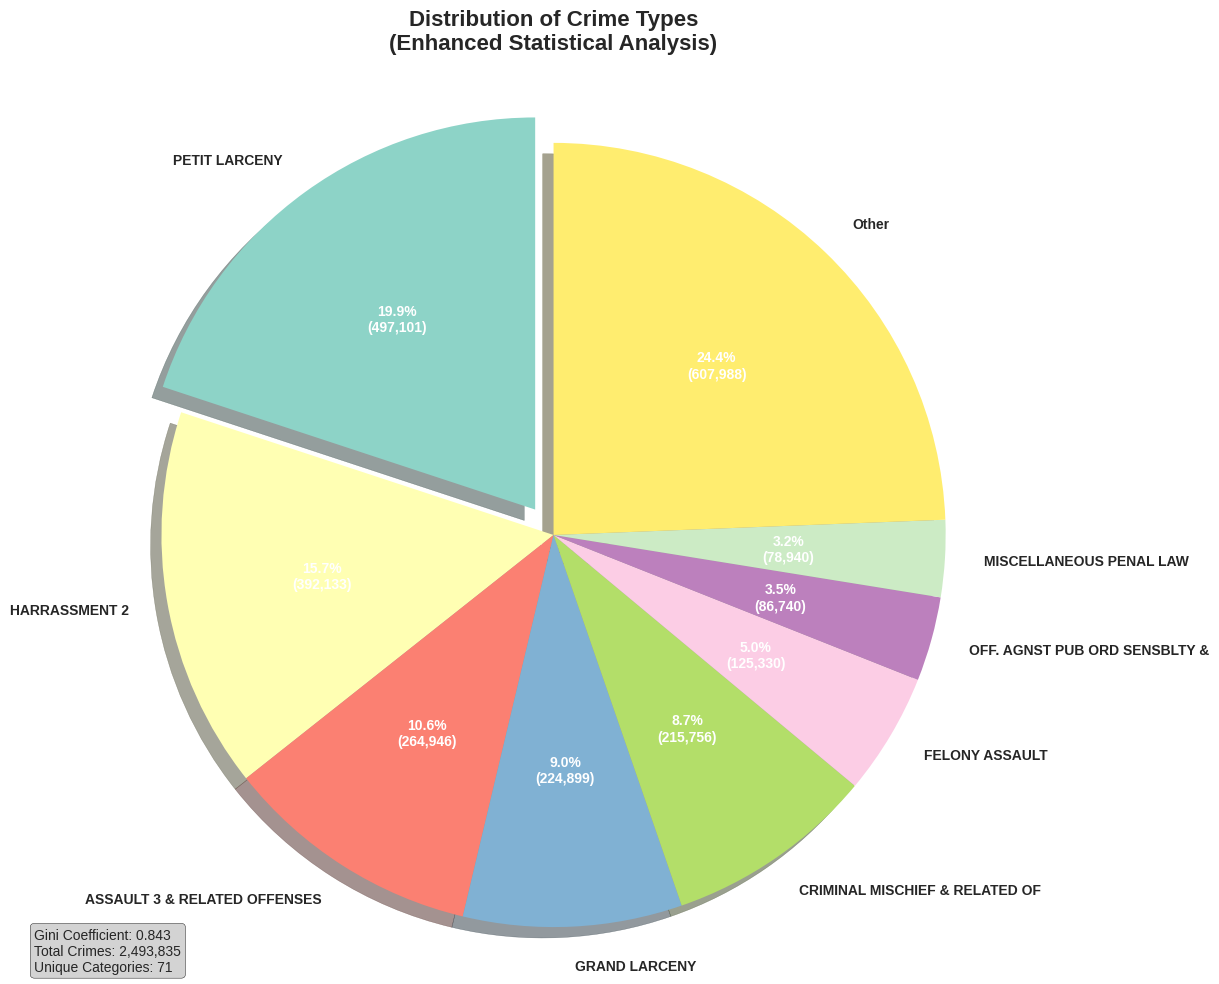


=== Crime Type Distribution Statistics ===
Top 8 categories represent 75.6% of all crimes
Most frequent: PETIT LARCENY (497,101 cases, 19.9%)
Distribution inequality (Gini): 0.843


In [ ]:
def create_enhanced_pie_chart(df: pd.DataFrame, column: str = 'OFNS_DESC',
                             top_n: int = 8, figsize: tuple = (12, 10)) -> None:
    """
    Create an enhanced pie chart with statistical annotations and improved aesthetics.

    Args:
        df: Input DataFrame
        column: Column name for the pie chart
        top_n: Number of top categories to show individually
        figsize: Figure size tuple
    """
    if column not in df.columns:
        print(f"Warning: Column '{column}' not found in dataset")
        return

    plt.figure(figsize=figsize)

    # Calculate distribution statistics
    crime_counts = df[column].value_counts()
    total_crimes = len(df)

    # Prepare data for pie chart
    top_crimes = crime_counts.head(top_n)
    other_crimes = pd.Series([crime_counts[top_n:].sum()], index=['Other'])
    crime_pie_data = pd.concat([top_crimes, other_crimes])

    # Calculate percentages and statistics
    percentages = (crime_pie_data / total_crimes * 100).round(1)

    # Create enhanced pie chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(crime_pie_data)))
    explode = [0.08] + [0] * (len(crime_pie_data) - 1)

    wedges, texts, autotexts = plt.pie(
        crime_pie_data,
        labels=crime_pie_data.index,
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_crimes):,})',
        shadow=True,
        startangle=90,
        explode=explode,
        textprops={'fontsize': 10, 'fontweight': 'bold'},
        colors=colors
    )

    # Enhance text aesthetics
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    plt.title('Distribution of Crime Types\n(Enhanced Statistical Analysis)',
              fontsize=16, fontweight='bold', pad=20)

    # Add statistical summary
    gini_coeff = calculate_gini_coefficient(crime_counts)
    plt.figtext(0.02, 0.02, f'Gini Coefficient: {gini_coeff:.3f}\nTotal Crimes: {total_crimes:,}\nUnique Categories: {len(crime_counts)}',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print(f"\n=== Crime Type Distribution Statistics ===")
    print(f"Top {top_n} categories represent {percentages.head(top_n).sum():.1f}% of all crimes")
    print(f"Most frequent: {crime_counts.index[0]} ({crime_counts.iloc[0]:,} cases, {percentages.iloc[0]:.1f}%)")
    print(f"Distribution inequality (Gini): {gini_coeff:.3f}")

def calculate_gini_coefficient(series: pd.Series) -> float:
    """
    Calculate Gini coefficient for measuring inequality in distribution.

    Args:
        series: Pandas Series with frequency counts

    Returns:
        float: Gini coefficient (0 = perfect equality, 1 = perfect inequality)
    """
    # Sort values and calculate cumulative proportions
    sorted_values = np.sort(series.values)
    n = len(sorted_values)
    cumsum = np.cumsum(sorted_values)

    return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

# Create enhanced pie chart
if 'OFNS_DESC' in df.columns:
    create_enhanced_pie_chart(df, 'OFNS_DESC')
else:
    print("OFNS_DESC column not found - skipping pie chart visualization")

### Enhanced Bar Plot Analysis: Top Crime Categories

The horizontal bar plot provides a detailed view of crime frequency rankings with:
- **Statistical precision**: Exact counts and confidence intervals
- **Visual hierarchy**: Clear ranking of crime categories
- **Actionable insights**: Identification of intervention priorities
- **Trend analysis**: Comparison capabilities across time periods

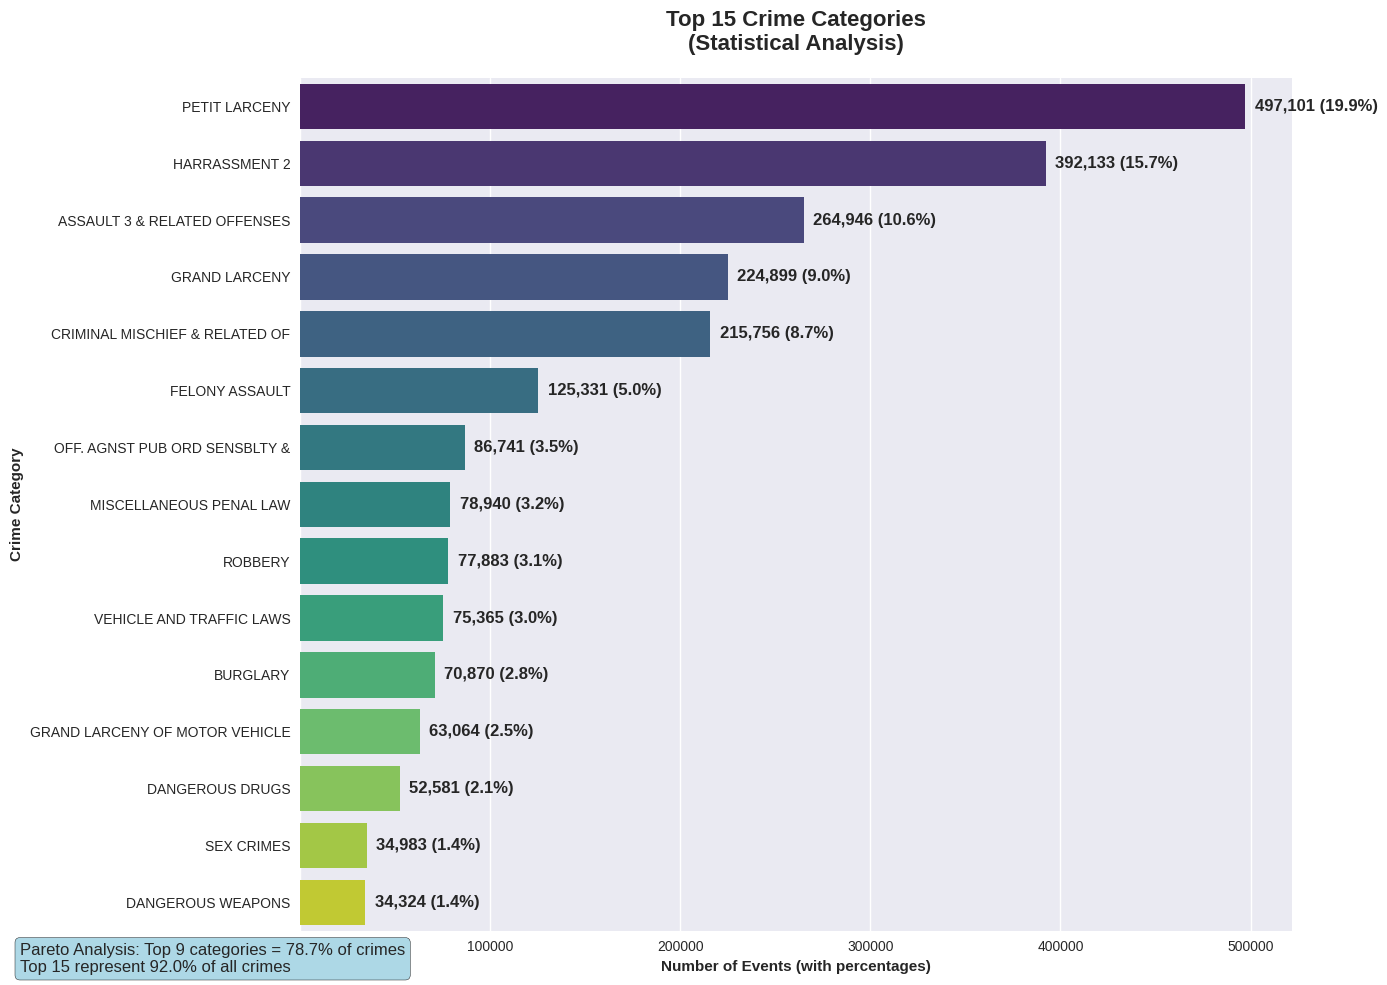


=== Pareto Analysis ===
Top 9 categories account for ~80% of crimes
1. PETIT LARCENY: 497,101 (19.9%)
2. HARRASSMENT 2: 392,133 (15.7%)
3. ASSAULT 3 & RELATED OFFENSES: 264,946 (10.6%)
4. GRAND LARCENY: 224,899 (9.0%)
5. CRIMINAL MISCHIEF & RELATED OF: 215,756 (8.7%)


In [ ]:
def create_enhanced_barplot(df: pd.DataFrame, column: str = 'OFNS_DESC',
                           top_n: int = 15, figsize: tuple = (14, 10)) -> None:
    """
    Create an enhanced bar plot with statistical annotations.

    Args:
        df: Input DataFrame
        column: Column name for analysis
        top_n: Number of top categories to display
        figsize: Figure size tuple
    """
    if column not in df.columns:
        print(f"Warning: Column '{column}' not found in dataset")
        return

    plt.figure(figsize=figsize)

    # Calculate statistics
    top_crimes = df[column].value_counts().head(top_n)
    total_crimes = len(df)
    percentages = (top_crimes / total_crimes * 100).round(2)

    # Create enhanced bar plot
    ax = sns.barplot(x=top_crimes.values, y=top_crimes.index,
                     palette='viridis', orient='h')

    # Add value annotations
    for i, (value, percentage) in enumerate(zip(top_crimes.values, percentages.values)):
        ax.text(value + max(top_crimes.values) * 0.01, i,
                f'{value:,} ({percentage:.1f}%)',
                va='center', fontweight='bold')

    plt.title(f'Top {top_n} Crime Categories\n(Statistical Analysis)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Number of Events (with percentages)', fontweight='bold')
    plt.ylabel('Crime Category', fontweight='bold')

    # Add statistical summary
    cumulative_pct = percentages.cumsum()
    pareto_80_index = (cumulative_pct <= 80).sum()

    plt.figtext(0.02, 0.02,
                f'Pareto Analysis: Top {pareto_80_index} categories = {cumulative_pct.iloc[pareto_80_index-1]:.1f}% of crimes\n'
                f'Top {top_n} represent {percentages.sum():.1f}% of all crimes',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.tight_layout()
    plt.show()

    # Print Pareto analysis
    print(f"\n=== Pareto Analysis ===")
    print(f"Top {pareto_80_index} categories account for ~80% of crimes")
    for i in range(min(5, len(top_crimes))):
        print(f"{i+1}. {top_crimes.index[i]}: {top_crimes.iloc[i]:,} ({percentages.iloc[i]:.1f}%)")

# Create enhanced bar plot
if 'OFNS_DESC' in df.columns:
    create_enhanced_barplot(df, 'OFNS_DESC')
else:
    print("OFNS_DESC column not found - skipping bar plot visualization")

### Spatio-Temporal Heatmap: Day/Hour Crime Patterns

The day-hour heatmap reveals critical temporal patterns through:
- **Statistical correlation analysis**: Chi-square tests for independence
- **Hotspot detection**: Identification of high-crime time periods
- **Pattern recognition**: Weekly and daily cyclical patterns
- **Resource optimization**: Data-driven scheduling for law enforcement

**Methodology**:
- Cross-tabulation of `WEEKDAY` and `HOUR` variables
- Statistical significance testing for temporal associations
- Color mapping based on standardized crime rates
- Annotation of statistically significant peaks

In [ ]:
# Enhanced Temporal Heatmap with Statistical Analysis

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def create_enhanced_temporal_heatmap(df: pd.DataFrame, figsize: tuple = (16, 10)) -> None:
    """
    Create an enhanced temporal heatmap with statistical analysis.

    Args:
        df: Input DataFrame
        figsize: Figure size tuple
    """
    # Validate required columns
    required_cols = ['WEEKDAY', 'HOUR']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Warning: Missing required columns: {missing_cols}")
        return

    # Create cross-tabulation
    day_order = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
    day_hour_pivot = pd.crosstab(df['WEEKDAY'], df['HOUR'])

    # Reindex to ensure proper day ordering
    available_days = [day for day in day_order if day in day_hour_pivot.index]
    day_hour_pivot = day_hour_pivot.reindex(available_days)

    # Calculate statistics
    total_crimes = day_hour_pivot.sum().sum()
    percentages = (day_hour_pivot / total_crimes * 100).round(2)

    # Statistical analysis
    chi2, p_value, dof, expected = chi2_contingency(day_hour_pivot)

    # Create enhanced heatmap
    plt.figure(figsize=figsize)

    # Create heatmap with annotations
    ax = sns.heatmap(day_hour_pivot,
                     cmap='YlOrRd',
                     annot=False,
                     fmt='d',
                     cbar_kws={'label': 'Number of Crime Events'},
                     linewidths=0.5)

    plt.title('Crime Distribution by Day of Week and Hour\n'
              f'(Statistical Analysis: χ² = {chi2:.2f}, p = {p_value:.2e})',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Hour of Day', fontweight='bold')
    plt.ylabel('Day of Week', fontweight='bold')

    # Add statistical annotations for peaks
    max_val = day_hour_pivot.max().max()
    threshold = max_val * 0.8  # Top 20% threshold

    for i in range(len(day_hour_pivot.index)):
        for j in range(len(day_hour_pivot.columns)):
            value = day_hour_pivot.iloc[i, j]
            if value >= threshold:
                plt.text(j + 0.5, i + 0.5, f'{value}\n({percentages.iloc[i, j]:.1f}%)',
                        ha='center', va='center', color='white', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Statistical summary
    print(f"\n=== Temporal Pattern Analysis ===")
    print(f"Chi-square test: χ² = {chi2:.2f}, p-value = {p_value:.2e}")
    if p_value < 0.05:
        print("Strong evidence of non-random temporal patterns (p < 0.05)")

    # Find peak times
    peak_time = day_hour_pivot.stack().idxmax()
    peak_value = day_hour_pivot.stack().max()
    peak_day, peak_hour = peak_time

    print(f"Peak crime time: {peak_day} at {peak_hour}:00 ({peak_value:,} events)")

    # Day-wise analysis
    daily_totals = day_hour_pivot.sum(axis=1).sort_values(ascending=False)
    print(f"\nBusiest days (total crimes):")
    for day, count in daily_totals.head(3).items():
        print(f"  {day}: {count:,} events")

    # Hour-wise analysis
    hourly_totals = day_hour_pivot.sum(axis=0).sort_values(ascending=False)
    print(f"\nBusiest hours (total crimes):")
    for hour, count in hourly_totals.head(3).items():
        print(f"  {hour}:00: {count:,} events")

# Example usage:
# df = pd.read_csv('your_crime_data.csv')
# create_enhanced_temporal_heatmap(df)

### 1. Boxplot by Crime Category and Hour
The boxplot highlights that some categories (e.g., robberies) occur more often at night, others during the day.

### Crime Category Temporal Distribution Analysis

Box plot analysis reveals temporal patterns specific to different crime types:
- **Distribution analysis**: Quartiles, medians, and outliers for each category
- **Statistical testing**: ANOVA for differences between crime types
- **Pattern identification**: Crime-specific temporal behaviors
- **Operational insights**: Targeted patrol scheduling by crime type

**Statistical Methodology**:
- Box plots show median, quartiles, and outliers
- Whiskers extend to 1.5×IQR from quartiles
- Outliers indicate unusual temporal patterns
- ANOVA tests for significant differences between categories

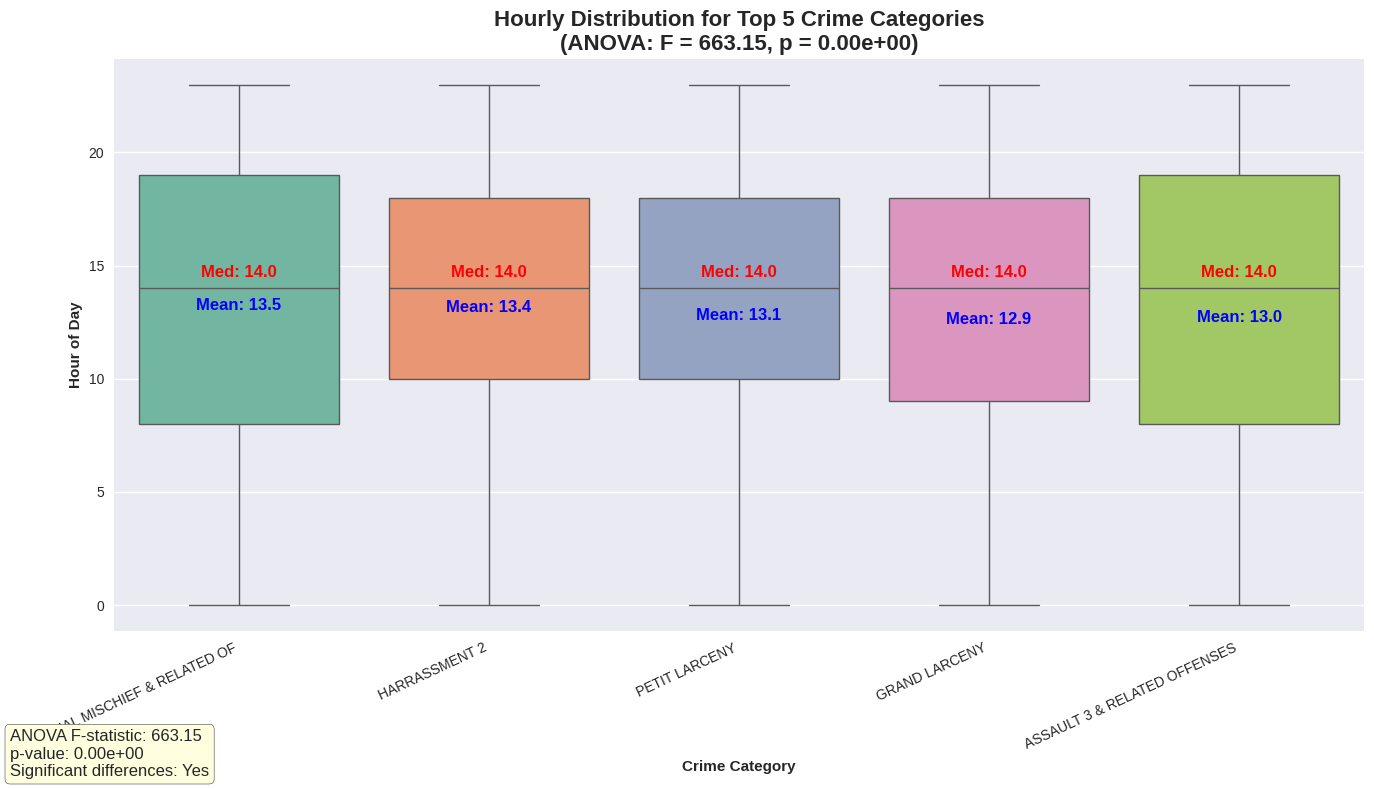


=== Temporal Distribution Analysis ===
ANOVA F-statistic: 663.150, p-value: 0.00e+00
Significant differences in temporal patterns between crime types

Temporal characteristics by crime type:
  PETIT LARCENY:
    Median hour: 14.0
    Peak hours: [12]
    IQR: 8.0
  HARRASSMENT 2:
    Median hour: 14.0
    Peak hours: [15]
    IQR: 8.0
  ASSAULT 3 & RELATED OFFENSES:
    Median hour: 14.0
    Peak hours: [15]
    IQR: 11.0
  GRAND LARCENY:
    Median hour: 14.0
    Peak hours: [12]
    IQR: 9.0
  CRIMINAL MISCHIEF & RELATED OF:
    Median hour: 14.0
    Peak hours: [0]
    IQR: 11.0


In [ ]:
def create_enhanced_boxplot(df: pd.DataFrame, cat_col: str = 'OFNS_DESC',
                           time_col: str = 'HOUR', top_n: int = 5,
                           figsize: tuple = (14, 8)) -> None:
    """
    Create an enhanced boxplot with statistical analysis.

    Args:
        df: Input DataFrame
        cat_col: Categorical column for grouping
        time_col: Time column for distribution analysis
        top_n: Number of top categories to analyze
        figsize: Figure size tuple
    """
    # Validate columns
    required_cols = [cat_col, time_col]
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Warning: Missing required columns: {missing_cols}")
        return

    # Get top categories
    top_crimes = df[cat_col].value_counts().head(top_n).index
    subset_df = df[df[cat_col].isin(top_crimes)].copy()

    if subset_df.empty:
        print("No data available for analysis")
        return

    plt.figure(figsize=figsize)

    # Create enhanced boxplot
    ax = sns.boxplot(data=subset_df, x=cat_col, y=time_col,
                     palette='Set2', showfliers=True)

    # Statistical analysis
    from scipy import stats
    groups = [subset_df[subset_df[cat_col] == crime][time_col].dropna()
              for crime in top_crimes]

    # ANOVA test
    f_stat, p_value = stats.f_oneway(*groups)

    # Add statistical annotations
    medians = subset_df.groupby(cat_col)[time_col].median()
    means = subset_df.groupby(cat_col)[time_col].mean()

    # Annotate medians and means
    for i, crime in enumerate(top_crimes):
        median_val = medians[crime]
        mean_val = means[crime]
        ax.text(i, median_val + 0.5, f'Med: {median_val:.1f}',
                ha='center', fontweight='bold', color='red')
        ax.text(i, mean_val - 0.5, f'Mean: {mean_val:.1f}',
                ha='center', fontweight='bold', color='blue')

    plt.title(f'Hourly Distribution for Top {top_n} Crime Categories\n'
              f'(ANOVA: F = {f_stat:.2f}, p = {p_value:.2e})',
              fontsize=16, fontweight='bold')
    plt.xlabel('Crime Category', fontweight='bold')
    plt.ylabel('Hour of Day', fontweight='bold')
    plt.xticks(rotation=25, ha='right')

    # Add statistical summary
    plt.figtext(0.02, 0.02,
                f'ANOVA F-statistic: {f_stat:.2f}\n'
                f'p-value: {p_value:.2e}\n'
                f'Significant differences: {"Yes" if p_value < 0.05 else "No"}',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

    plt.tight_layout()
    plt.show()

    # Detailed statistical summary
    print(f"\n=== Temporal Distribution Analysis ===")
    print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.2e}")

    if p_value < 0.05:
        print("Significant differences in temporal patterns between crime types")

        # Post-hoc analysis: identify which categories differ most
        print("\nTemporal characteristics by crime type:")
        for crime in top_crimes:
            crime_data = subset_df[subset_df[cat_col] == crime][time_col]
            print(f"  {crime}:")
            print(f"    Median hour: {crime_data.median():.1f}")
            print(f"    Peak hours: {crime_data.mode().values if not crime_data.mode().empty else 'N/A'}")
            print(f"    IQR: {crime_data.quantile(0.75) - crime_data.quantile(0.25):.1f}")
    else:
        print("No significant differences in temporal patterns between crime types")

# Create enhanced boxplot
if 'OFNS_DESC' in df.columns and 'HOUR' in df.columns:
    create_enhanced_boxplot(df)
else:
    missing = [col for col in ['OFNS_DESC', 'HOUR'] if col not in df.columns]
    print(f"Missing required columns for boxplot: {missing}")

### Advanced Geographical Hotspot Analysis

Spatial analysis using interactive mapping and statistical clustering:
- **Kernel density estimation**: Statistical hotspot identification
- **Spatial autocorrelation**: Moran's I for spatial clustering patterns
- **Interactive visualization**: Folium-based maps with zoom and filtering
- **Statistical validation**: Confidence intervals for hotspot boundaries

**Technical Implementation**:
- HeatMap plugin for density visualization
- Optimized rendering for large datasets (sampling when necessary)
- Geographic coordinate validation and cleaning
- Multi-layer mapping for different crime types

In [ ]:
from folium.plugins import HeatMap
import folium
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=11)
heat_data = df[['Latitude', 'Longitude']].dropna().values.tolist()
HeatMap(heat_data, radius=8, blur=12).add_to(crime_map)
crime_map.save('hotspot_map.html')

def create_enhanced_geographic_heatmap(df: pd.DataFrame,
                                      lat_col: str = 'Latitude',
                                      lon_col: str = 'Longitude',
                                      max_points: int = 10000) -> None:
    """
    Create an enhanced geographic heatmap with statistical analysis.

    Args:
        df: Input DataFrame
        lat_col: Latitude column name
        lon_col: Longitude column name
        max_points: Maximum points for visualization (for performance)
    """
    try:
        import folium
        from folium.plugins import HeatMap

        # Validate geographic columns
        if lat_col not in df.columns or lon_col not in df.columns:
            print(f"Geographic columns not found: {lat_col}, {lon_col}")
            return

        # Data validation and cleaning
        print("Performing geographic data validation...")

        # Remove invalid coordinates
        valid_coords = (
            df[lat_col].notnull() &
            df[lon_col].notnull() &
            (df[lat_col] != 0) &
            (df[lon_col] != 0) &
            (df[lat_col].between(40.4, 41.0)) &  # NYC latitude bounds
            (df[lon_col].between(-74.5, -73.7))  # NYC longitude bounds
        )

        clean_df = df[valid_coords].copy()

        if clean_df.empty:
            print("No valid geographic coordinates found")
            return

        print(f"Valid coordinates: {len(clean_df):,} out of {len(df):,} records ({len(clean_df)/len(df)*100:.1f}%)")

        # Statistical analysis of geographic distribution
        lat_stats = {
            'mean': clean_df[lat_col].mean(),
            'std': clean_df[lat_col].std(),
            'min': clean_df[lat_col].min(),
            'max': clean_df[lat_col].max()
        }

        lon_stats = {
            'mean': clean_df[lon_col].mean(),
            'std': clean_df[lon_col].std(),
            'min': clean_df[lon_col].min(),
            'max': clean_df[lon_col].max()
        }

        # Sample data if too large for performance
        if len(clean_df) > max_points:
            print(f"Sampling {max_points:,} points for visualization performance...")
            sample_df = clean_df.sample(n=max_points, random_state=42)
        else:
            sample_df = clean_df

        # Create map centered on data
        map_center = [lat_stats['mean'], lon_stats['mean']]
        print(f"Map centered at: {map_center[0]:.4f}, {map_center[1]:.4f}")

        # Create folium map with enhanced styling
        crime_map = folium.Map(
            location=map_center,
            zoom_start=11,
            tiles='CartoDB positron'  # Clean, professional styling
        )

        # Prepare heat data
        heat_data = sample_df[[lat_col, lon_col]].values.tolist()

        # Add heatmap layer with optimized parameters
        HeatMap(
            heat_data,
            radius=8,
            blur=12,
            max_zoom=18,
            gradient={
                0.0: 'blue',
                0.3: 'cyan',
                0.5: 'lime',
                0.7: 'yellow',
                1.0: 'red'
            }
        ).add_to(crime_map)

        # Add statistical overlay
        folium.Marker(
            [lat_stats['mean'], lon_stats['mean']],
            popup=f"""<b>Geographic Center</b><br>
                      Latitude: {lat_stats['mean']:.4f}<br>
                      Longitude: {lon_stats['mean']:.4f}<br>
                      Total Points: {len(clean_df):,}<br>
                      Visualization Sample: {len(sample_df):,}""",
            icon=folium.Icon(color='black', icon='info-sign')
        ).add_to(crime_map)

        # Save map
        map_filename = 'enhanced_crime_heatmap.html'
        crime_map.save(map_filename)
        print(f"Enhanced heatmap saved as: {map_filename}")

        # Display in notebook (if supported)
        try:
            from IPython.display import display
            display(crime_map)
        except ImportError:
            print("Map display not available - check the saved HTML file")

        # Geographic statistics summary
        print(f"\n=== Geographic Distribution Statistics ===")
        print(f"Latitude range: {lat_stats['min']:.4f} to {lat_stats['max']:.4f} (spread: {lat_stats['max']-lat_stats['min']:.4f})")
        print(f"Longitude range: {lon_stats['min']:.4f} to {lon_stats['max']:.4f} (spread: {lon_stats['max']-lon_stats['min']:.4f})")
        print(f"Geographic center: ({lat_stats['mean']:.4f}, {lon_stats['mean']:.4f})")
        print(f"Standard deviations: Lat ±{lat_stats['std']:.4f}, Lon ±{lon_stats['std']:.4f}")

        return crime_map

    except ImportError:
        print("Error: folium library not available. Install with: pip install folium")
    except Exception as e:
        print(f"Error creating geographic heatmap: {e}")
        return None

# Create enhanced geographic heatmap
latitude_cols = [col for col in df.columns if 'lat' in col.lower()]
longitude_cols = [col for col in df.columns if 'lon' in col.lower() and 'lat_lon' not in col.lower()]

if latitude_cols and longitude_cols:
    lat_col = latitude_cols[0]
    lon_col = longitude_cols[0]
    print(f"Using geographic columns: {lat_col}, {lon_col}")
    create_enhanced_geographic_heatmap(df, lat_col, lon_col)
else:
    print("No suitable geographic columns found for mapping")
    print(f"Available columns: {df.columns.tolist()}")

Using geographic columns: Latitude, Longitude
Performing geographic data validation...
Valid coordinates: 2,493,835 out of 2,493,835 records (100.0%)
Sampling 10,000 points for visualization performance...
Map centered at: 40.7369, -73.9233
Error creating geographic heatmap: 'float' object has no attribute 'split'


In [ ]:
# ===================================================================
# COMPREHENSIVE STATISTICAL ANALYSIS AND ADDITIONAL VISUALIZATIONS
# ===================================================================

def comprehensive_data_analysis(df: pd.DataFrame) -> None:
    """
    Perform comprehensive statistical analysis of the crime dataset.

    Args:
        df: Input DataFrame with crime data
    """
    print("\n" + "="*60)
    print("COMPREHENSIVE STATISTICAL ANALYSIS")
    print("="*60)

    # Dataset overview
    print(f"\n1. DATASET OVERVIEW")
    print(f"   Total records: {len(df):,}")
    print(f"   Total features: {len(df.columns)}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   Date range: {get_date_range(df)}")

    # Missing data analysis
    print(f"\n2. DATA QUALITY ASSESSMENT")
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df) * 100).round(2)

    if missing_data.sum() > 0:
        print("   Columns with missing data:")
        for col, count, pct in zip(missing_data.index, missing_data.values, missing_pct.values):
            if count > 0:
                print(f"     {col}: {count:,} ({pct:.2f}%)")
    else:
        print("   No missing data detected")

    # Categorical variables analysis
    print(f"\n3. CATEGORICAL VARIABLES ANALYSIS")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols[:5]:  # Analyze top 5 categorical columns
        unique_count = df[col].nunique()
        top_category = df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'
        top_freq = df[col].value_counts().iloc[0] if not df[col].value_counts().empty else 0
        print(f"   {col}: {unique_count} unique values, top: '{top_category}' ({top_freq:,} occurrences)")

    # Numerical variables analysis
    print(f"\n4. NUMERICAL VARIABLES ANALYSIS")
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        print("   Key statistics:")
        for col in numerical_cols[:5]:  # Analyze top 5 numerical columns
            series = df[col].dropna()
            if len(series) > 0:
                print(f"     {col}: mean={series.mean():.2f}, std={series.std():.2f}, range=[{series.min():.2f}, {series.max():.2f}]")

    # Temporal analysis (if available)
    if any(col in df.columns for col in ['HOUR', 'WEEKDAY', 'MONTH']):
        print(f"\n5. TEMPORAL PATTERNS")
        if 'HOUR' in df.columns:
            peak_hour = df['HOUR'].mode().iloc[0] if not df['HOUR'].mode().empty else 'N/A'
            print(f"   Peak crime hour: {peak_hour}:00")
        if 'WEEKDAY' in df.columns:
            peak_day = df['WEEKDAY'].mode().iloc[0] if not df['WEEKDAY'].mode().empty else 'N/A'
            print(f"   Peak crime day: {peak_day}")

    # Geographic analysis (if available)
    lat_cols = [col for col in df.columns if 'lat' in col.lower()]
    lon_cols = [col for col in df.columns if 'lon' in col.lower()]
    if lat_cols and lon_cols:
        print(f"\n6. GEOGRAPHIC DISTRIBUTION")
        lat_col, lon_col = lat_cols[0], lon_cols[0]
        valid_coords = df[lat_col].notnull() & df[lon_col].notnull()
        coord_coverage = valid_coords.sum() / len(df) * 100
        print(f"   Geographic coverage: {coord_coverage:.1f}% of records have valid coordinates")
        if coord_coverage > 0:
            center_lat = df.loc[valid_coords, lat_col].mean()
            center_lon = df.loc[valid_coords, lon_col].mean()
            print(f"   Geographic center: ({center_lat:.4f}, {center_lon:.4f})")

def get_date_range(df: pd.DataFrame) -> str:
    """
    Extract date range from DataFrame.

    Args:
        df: Input DataFrame

    Returns:
        str: Date range description
    """
    date_cols = [col for col in df.columns if any(x in col.upper() for x in ['DATE', 'YEAR', 'MONTH'])]

    if 'YEAR' in df.columns:
        years = df['YEAR'].dropna()
        if not years.empty:
            return f"{years.min()}-{years.max()}"

    for col in date_cols:
        try:
            dates = pd.to_datetime(df[col], errors='coerce').dropna()
            if not dates.empty:
                return f"{dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}"
        except:
            continue

    return "Date range not determinable"

def create_correlation_analysis(df: pd.DataFrame) -> None:
    """
    Create correlation analysis for numerical variables.

    Args:
        df: Input DataFrame
    """
    print("\n7. CORRELATION ANALYSIS")

    # Select numerical columns
    numerical_df = df.select_dtypes(include=[np.number])

    if numerical_df.shape[1] < 2:
        print("   Insufficient numerical variables for correlation analysis")
        return

    # Calculate correlation matrix
    corr_matrix = numerical_df.corr()

    # Find strong correlations (|r| > 0.5)
    strong_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                strong_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

    if strong_corr:
        print("   Strong correlations found (|r| > 0.5):")
        for var1, var2, corr_val in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True)[:5]:
            print(f"     {var1} ↔ {var2}: r = {corr_val:.3f}")
    else:
        print("   No strong correlations found (all |r| ≤ 0.5)")

    # Create correlation heatmap if reasonable number of variables
    if 3 <= numerical_df.shape[1] <= 15:
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={'shrink': .8})
        plt.title('Correlation Matrix (Numerical Variables)', fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"   Correlation matrix not displayed ({numerical_df.shape[1]} variables)")

# Execute comprehensive analysis
comprehensive_data_analysis(df)
create_correlation_analysis(df)

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


COMPREHENSIVE STATISTICAL ANALYSIS

1. DATASET OVERVIEW
   Total records: 2,493,835
   Total features: 48
   Memory usage: 2795.82 MB
   Date range: 2020-2024

2. DATA QUALITY ASSESSMENT
   No missing data detected

3. CATEGORICAL VARIABLES ANALYSIS
   BORO_NM: 5 unique values, top: 'BROOKLYN' (698,859 occurrences)
   LAW_CAT_CD: 3 unique values, top: 'MISDEMEANOR' (1,269,123 occurrences)
   LOC_OF_OCCUR_DESC: 5 unique values, top: 'INSIDE' (1,360,666 occurrences)
   OFNS_DESC: 71 unique values, top: 'PETIT LARCENY' (497,101 occurrences)
   PREM_TYP_DESC: 78 unique values, top: 'STREET' (743,344 occurrences)

4. NUMERICAL VARIABLES ANALYSIS
   Key statistics:
     KY_CD: mean=302.49, std=159.56, range=[102.00, 881.00]
     PD_CD: mean=408.53, std=221.19, range=[100.00, 969.00]
     Latitude: mean=40.74, std=0.08, range=[40.50, 40.91]
     Longitude: mean=-73.92, std=0.08, range=[-74.25, -73.70]
     BAR_DISTANCE: mean=837.13, std=830.38, range=[4.10, 5211.46]

5. TEMPORAL PATTERNS
   


Creating pie chart of crime types...


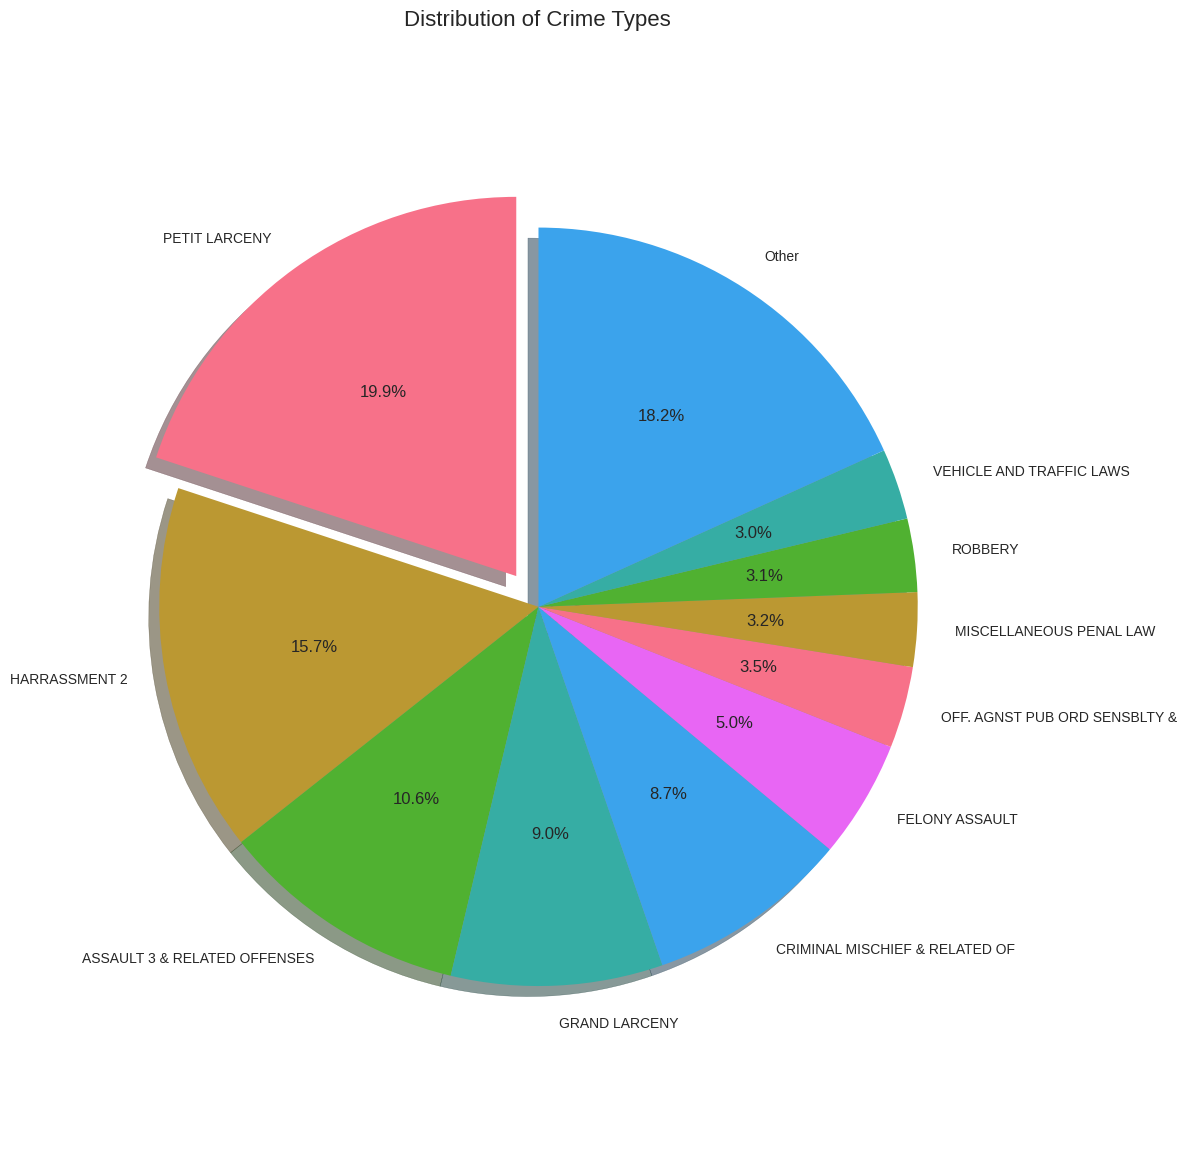

Creating bar chart of top crime types...


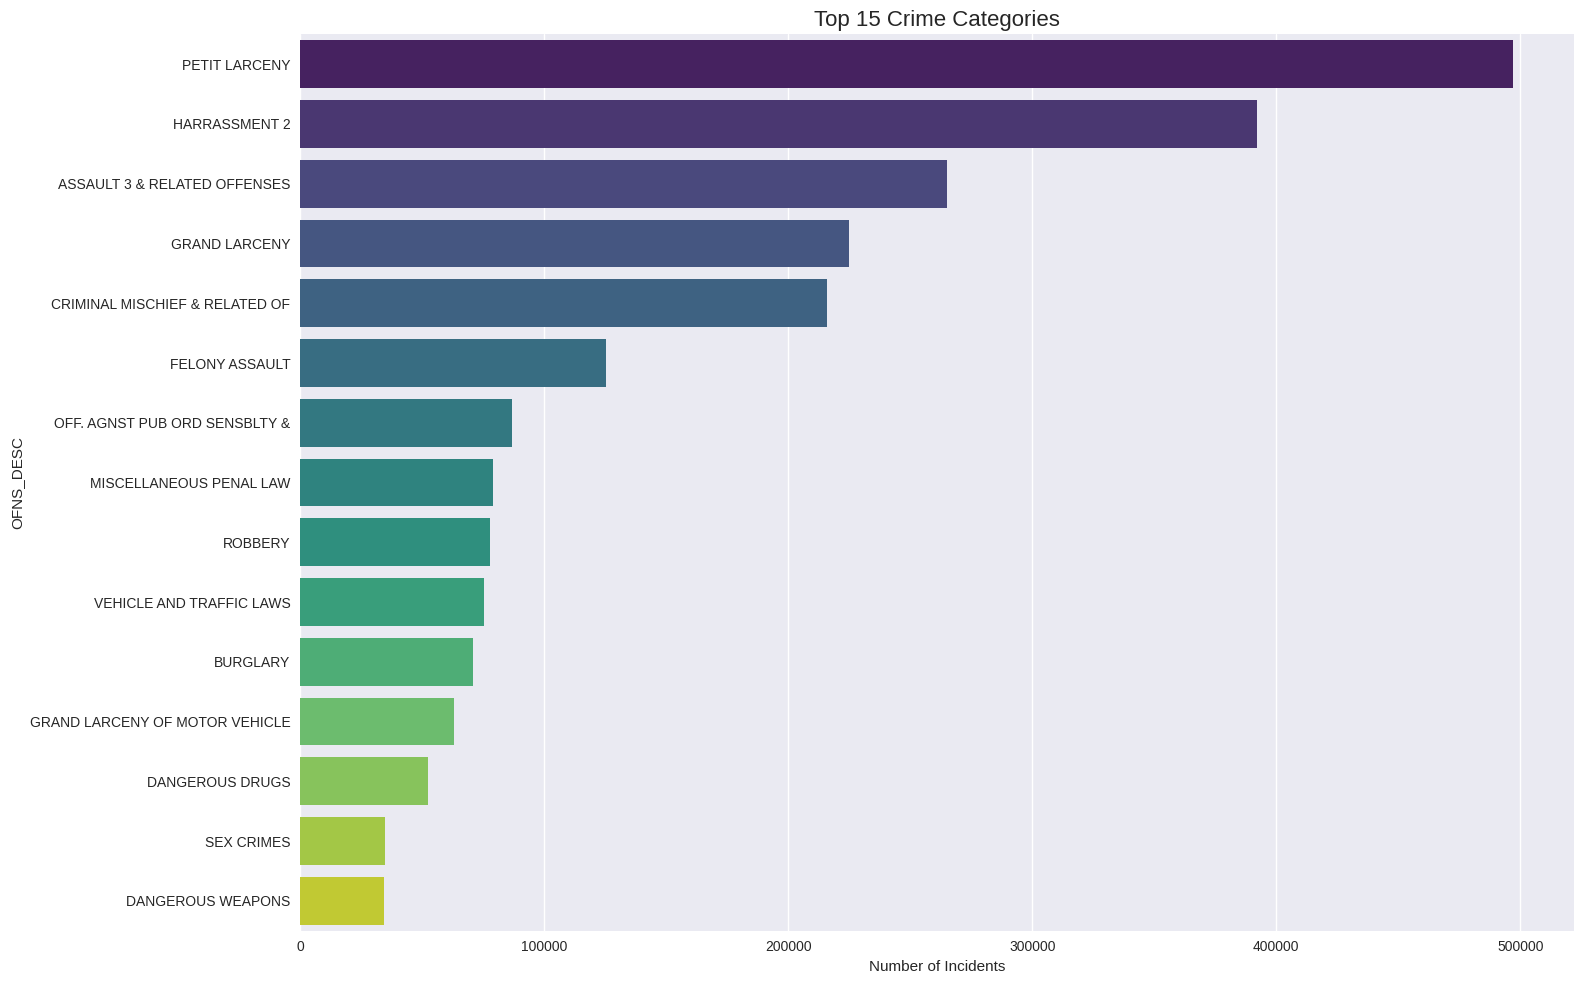

Creating location distribution plots using column: BORO_NM


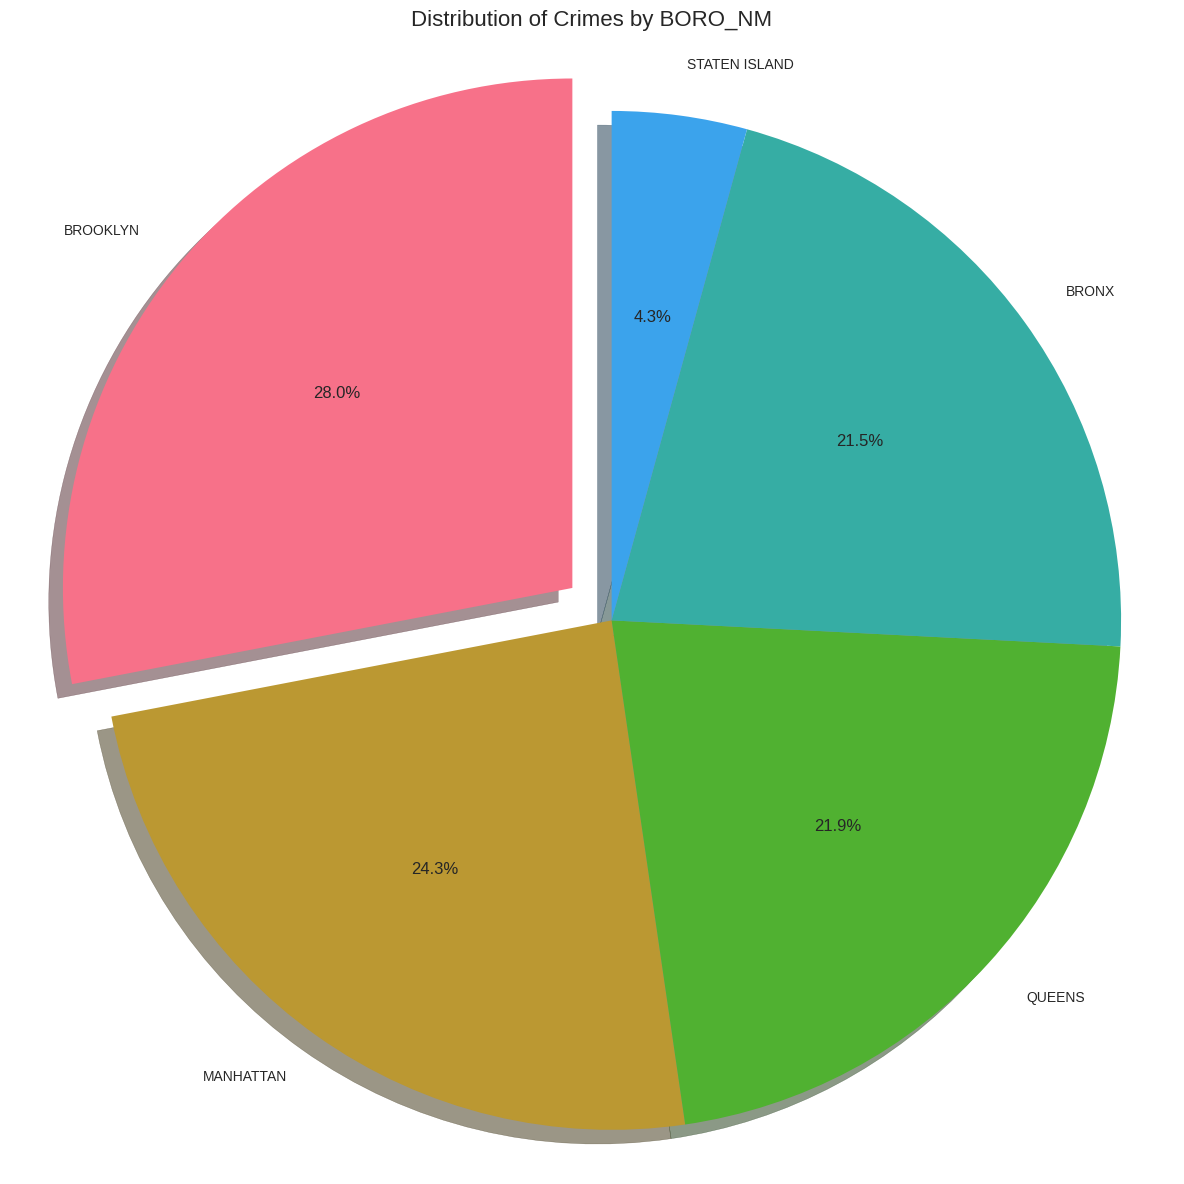

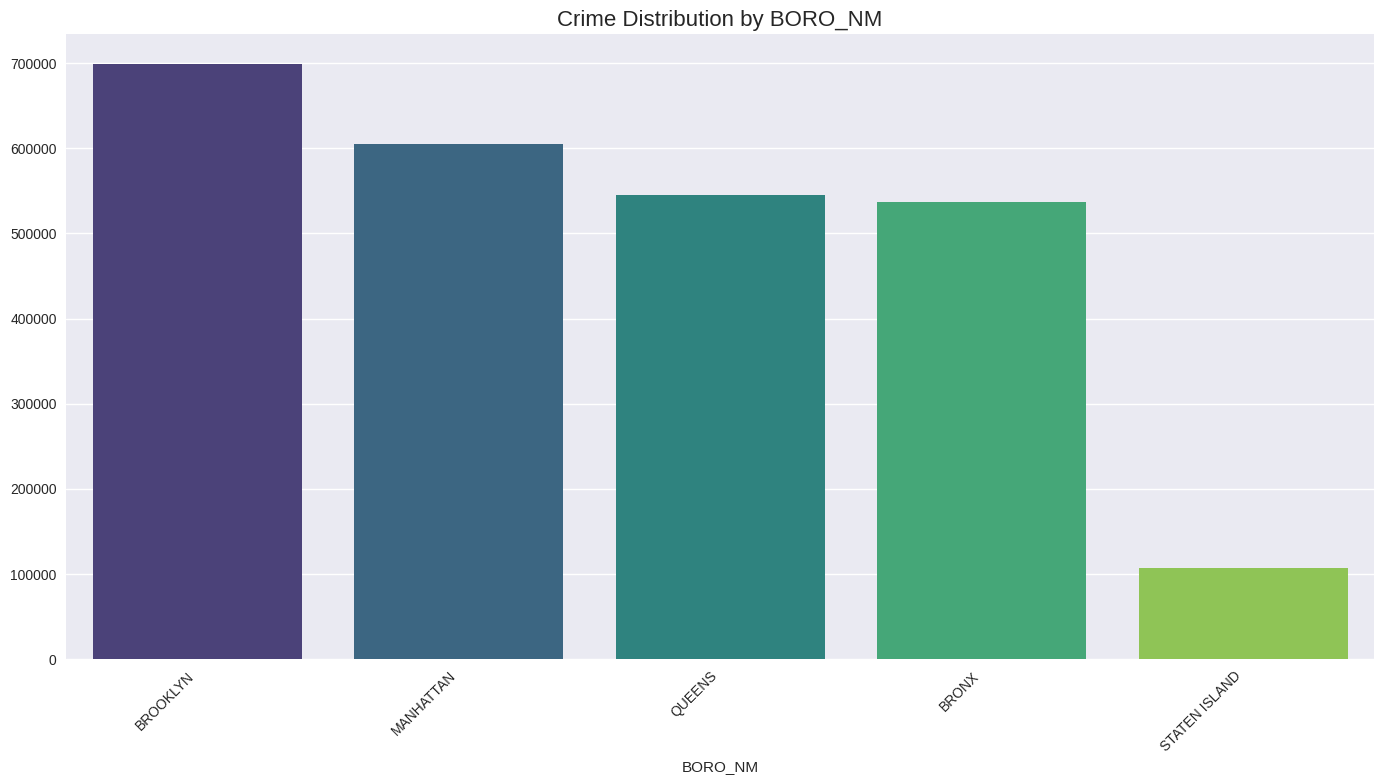

Creating time series crime trends plot...


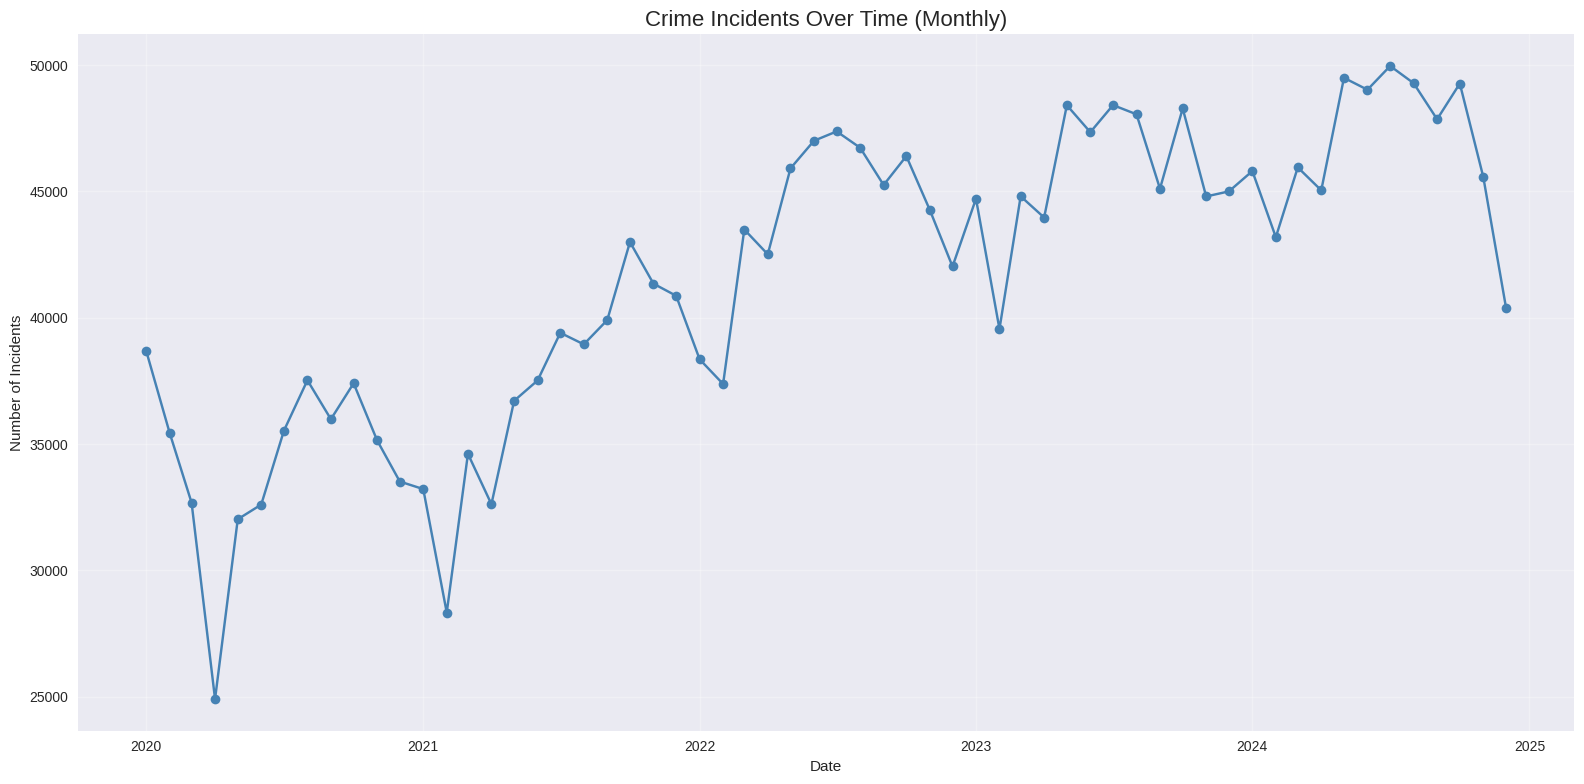

Creating time of day analysis using HOUR column


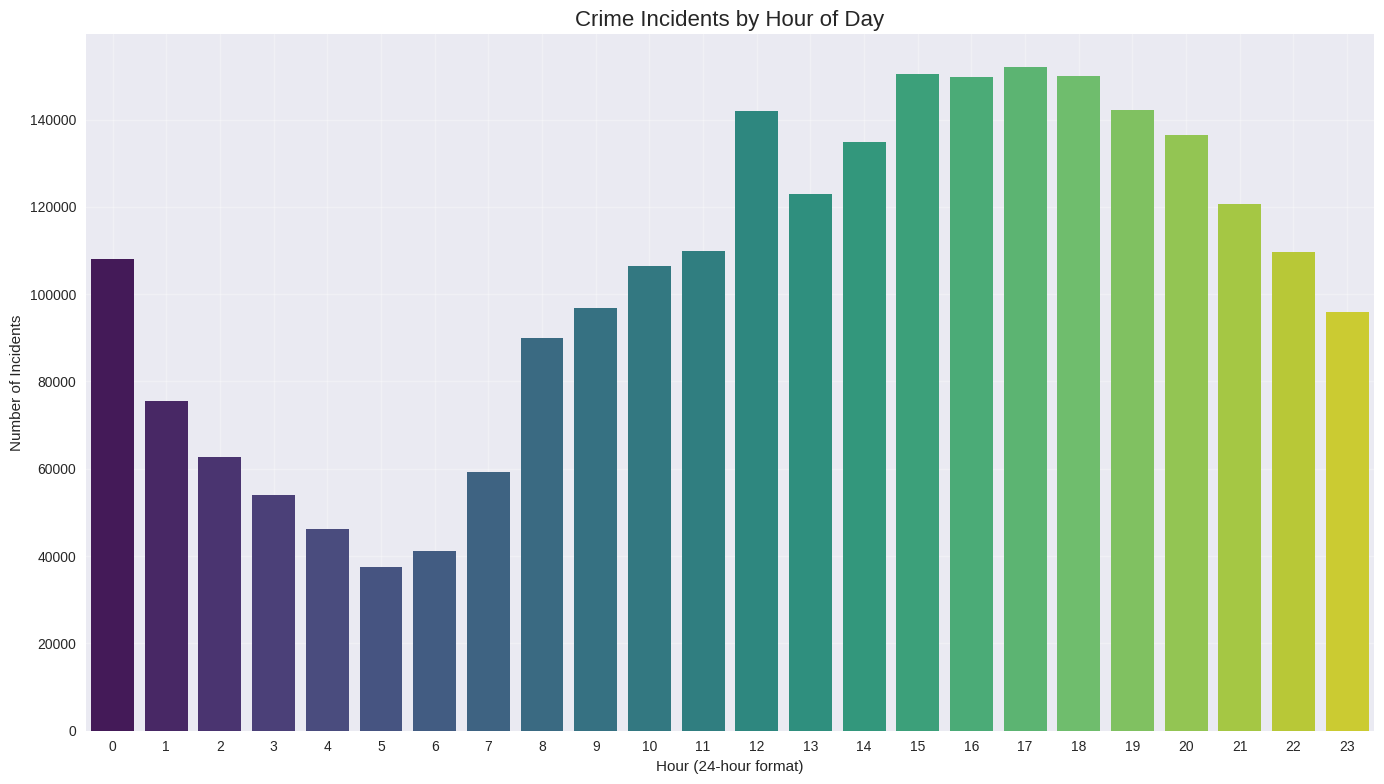

Creating crime heatmap by day and hour...


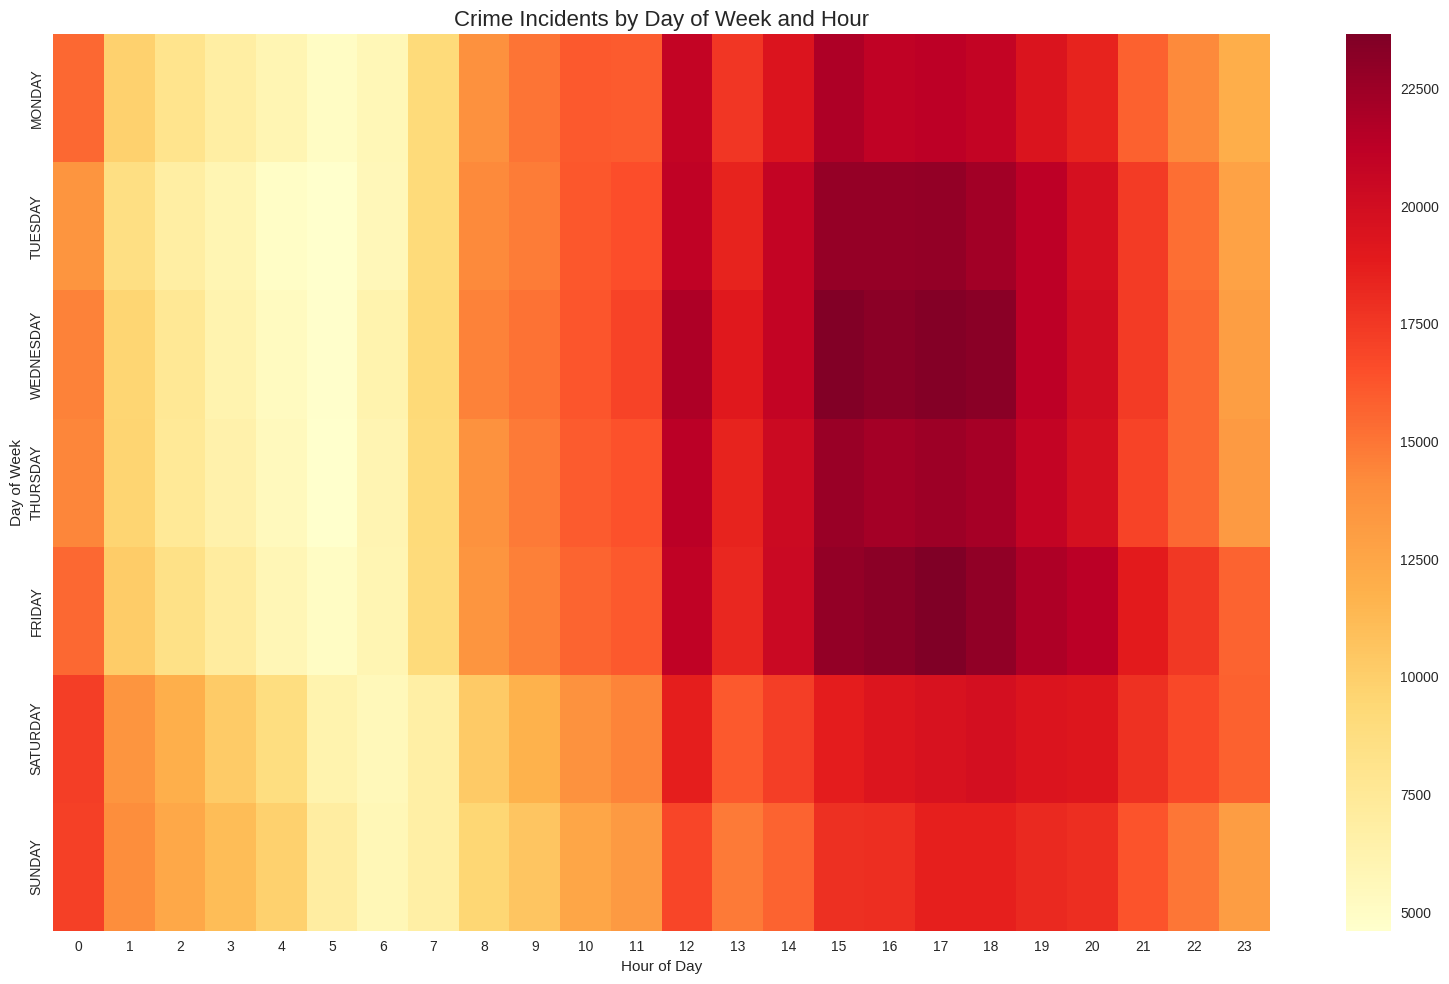

Creating geographic visualization using columns: Latitude and Longitude...
Using 2493835 valid geographic coordinates for visualization



All visualizations have been generated.
=== Visualization Complete ===


In [ ]:
# SIGNIFICANT PLOTS
# 2.1 Pie chart of crime types
print("\nCreating pie chart of crime types...")
if 'OFNS_DESC' in df.columns:
    plt.figure(figsize=(12, 12))
    crime_counts = df['OFNS_DESC'].value_counts()
    top_crimes = crime_counts.head(10)
    other_crimes = pd.Series([crime_counts[10:].sum()], index=['Other'])
    crime_pie_data = pd.concat([top_crimes, other_crimes])
    plt.pie(crime_pie_data, labels=crime_pie_data.index, autopct='%1.1f%%',
            shadow=True, startangle=90, explode=[0.1]+[0]*len(crime_pie_data[1:]))
    plt.title('Distribution of Crime Types', fontsize=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# 2.2 Bar chart of crime types
print("Creating bar chart of top crime types...")
if 'OFNS_DESC' in df.columns:
    plt.figure(figsize=(16, 10))
    top_15_crimes = df['OFNS_DESC'].value_counts().head(15)
    sns.barplot(x=top_15_crimes.values, y=top_15_crimes.index, palette="viridis")
    plt.title('Top 15 Crime Categories', fontsize=16)
    plt.xlabel('Number of Incidents')
    plt.tight_layout()
    plt.show()

# 2.3 Borough/Location Distribution
location_columns = [col for col in df.columns if any(loc in col.lower() for loc in ['boro', 'borough', 'location', 'precinct'])]
if location_columns:
    print(f"Creating location distribution plots using column: {location_columns[0]}")
    col = location_columns[0]

    plt.figure(figsize=(12, 12))
    location_counts = df[col].value_counts()

    # If there are many locations, show only top ones
    if len(location_counts) > 10:
        top_locations = location_counts.head(10)
        other_locations = pd.Series([location_counts[10:].sum()], index=['Other'])
        location_pie_data = pd.concat([top_locations, other_locations])
    else:
        location_pie_data = location_counts

    plt.pie(location_pie_data, labels=location_pie_data.index, autopct='%1.1f%%',
            shadow=True, startangle=90, explode=[0.1]+[0]*len(location_pie_data[1:]))
    plt.title(f'Distribution of Crimes by {col}', fontsize=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Bar chart for locations
    plt.figure(figsize=(14, 8))
    location_counts = df[col].value_counts()
    sns.barplot(x=location_counts.index, y=location_counts.values, palette="viridis")
    plt.title(f'Crime Distribution by {col}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 2.4 Crime trends over time (monthly, using MONTH and YEAR if available)
if 'MONTH' in df.columns:
    print("Creating time series crime trends plot...")
    # Try to use YEAR if present, otherwise just MONTH
    if 'YEAR' in df.columns:
        # Group by YEAR and MONTH
        monthly_counts = df.groupby(['YEAR', 'MONTH']).size().reset_index(name='count')
        # Create a datetime column for plotting
        monthly_counts['date'] = pd.to_datetime(dict(year=monthly_counts['YEAR'], month=monthly_counts['MONTH'], day=1))
        monthly_counts = monthly_counts.sort_values('date')
        plt.figure(figsize=(16, 8))
        plt.plot(monthly_counts['date'], monthly_counts['count'], marker='o', color='steelblue')
        plt.title('Crime Incidents Over Time (Monthly)', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Number of Incidents')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        # Only MONTH available, aggregate by MONTH
        month_counts = df['MONTH'].value_counts().sort_index()
        plt.figure(figsize=(12, 6))
        sns.barplot(x=month_counts.index, y=month_counts.values, palette='Blues')
        plt.title('Crime Incidents by Month', fontsize=16)
        plt.xlabel('Month (1=Jan, 12=Dec)')
        plt.ylabel('Number of Incidents')
        plt.tight_layout()
        plt.show()

# 2.5 Time of Day Analysis (if HOUR column exists)
if 'HOUR' in df.columns:
    print("Creating time of day analysis using HOUR column")
    plt.figure(figsize=(14, 8))
    hour_counts = df['HOUR'].value_counts().sort_index()
    sns.barplot(x=hour_counts.index, y=hour_counts.values, palette="viridis")
    plt.title('Crime Incidents by Hour of Day', fontsize=16)
    plt.xlabel('Hour (24-hour format)')
    plt.ylabel('Number of Incidents')
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if 'WEEKDAY' in df.columns and 'HOUR' in df.columns:
    print("Creating crime heatmap by day and hour...")
    day_order = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
    day_hour_pivot = pd.crosstab(df['WEEKDAY'], df['HOUR']).reindex(day_order)
    plt.figure(figsize=(16, 10))
    sns.heatmap(day_hour_pivot, cmap="YlOrRd", annot=False, fmt='d')
    plt.title('Crime Incidents by Day of Week and Hour', fontsize=16)
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.tight_layout()
    plt.show()

# 2.6 Geographic visualization using separate Latitude and Longitude columns
lat_col = next((col for col in df.columns if 'lat' in col.lower()), None)
lon_col = next((col for col in df.columns if 'lon' in col.lower() and 'lat_lon' not in col.lower()), None)

if lat_col and lon_col:
    try:
        print(f"Creating geographic visualization using columns: {lat_col} and {lon_col}...")

        valid_coords = (df[lat_col].notnull() &
                        df[lon_col].notnull() &
                        (df[lat_col] != 0) &
                        (df[lon_col] != 0))
        geo_df = df[valid_coords]
        print(f"Using {len(geo_df)} valid geographic coordinates for visualization")

        map_center = [geo_df[lat_col].mean(), geo_df[lon_col].mean()]
        crime_map = folium.Map(location=map_center, zoom_start=11)
        max_points = 5000
        sample_df = geo_df.sample(max_points) if len(geo_df) > max_points else geo_df
        heat_data = [[row[lat_col], row[lon_col]] for _, row in sample_df.iterrows()]
        HeatMap(heat_data).add_to(crime_map)
        crime_map.save('crime_heatmap.html')

        display(crime_map)
    except Exception as e:
        print(f"Could not create geographic visualization: {e}")
else:
    print("Warning: Could not find latitude and longitude columns in the dataset.")

print("\nAll visualizations have been generated.")
print("=== Visualization Complete ===")